# Average mutation functional effect shifts for a set of comparisons

Import Python modules.
We use `polyclonal` for the plotting:

In [1]:
import altair as alt

import dms_variants.utils

import pandas as pd

import polyclonal
import polyclonal.plot

import seaborn

This notebook is parameterized by `papermill`.
The next cell is tagged as `parameters` to get the passed parameters.

In [2]:
# this cell is tagged parameters for `papermill` parameterization
site_numbering_map_csv = None
params = None

In [3]:
# Parameters
params = {
    "comparisons": ["LibA-date_comparison-1", "LibA-date_comparison-2"],
    "lasso_shift": 0.0001,
    "title": "Comparison of functional effects from different dates (just a toy example)",
}
site_numbering_map_csv = "data/site_numbering_map.csv"

import os
os.chdir("../test_example")

Read the input data:

In [4]:
comparisons = params["comparisons"]

shifts = [
    pd.read_csv(
        f"results/func_effect_shifts/by_comparison/{c}_shifts.csv"
    ).assign(comparison=c)
    for c in comparisons
]

# check all shift comparisons are comparable:
for shift_df in shifts[1:]:
    if (shift_df.columns != shifts[0].columns).any():
        raise ValueError("comparisons do not all have the same columns")
    if set(shift_df["lasso_shift"]) != set(shifts[0]["lasso_shift"]):
        raise ValueError("comparisons do not all have the same `lasso_shifts`")

shifts = pd.concat(shifts)

# add a times_seen column that is the average of all of the times_seen
times_seen_cols = [c for c in shifts.columns if c.startswith("times_seen_")]
shifts["times_seen"] = shifts[times_seen_cols].mean(axis=1)

Plot correlation of shifts for each lasso shift, restricting to `times_seen` of 3 and not plotting shifts for wildtype residues.
In general, you might hope to find a lasso shift that has relatively few non-zero shifts, and those are correlated among comparisons.

/home/jbloom/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_69386/3468937908.py:27: UserWarning: The figure layout has changed to tight
  grid.fig.tight_layout()
/home/jbloom/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_69386/3468937908.py:27: UserWarning: The figure layout has changed to tight
  grid.fig.tight_layout()
/home/jbloom/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_69386/3468937908.py:27: UserWarning: The figure layout has changed to tight
  grid.fig.tight_layout()
/home/jbloom/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._fi

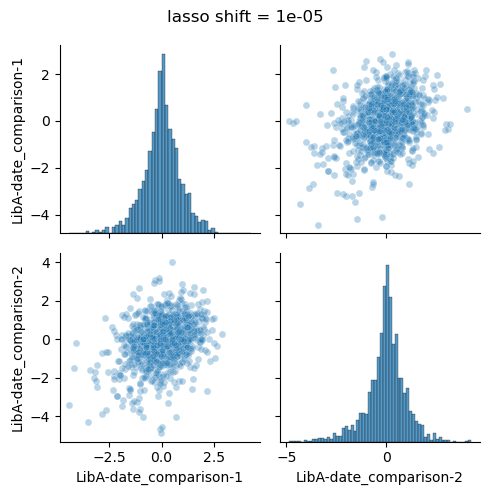

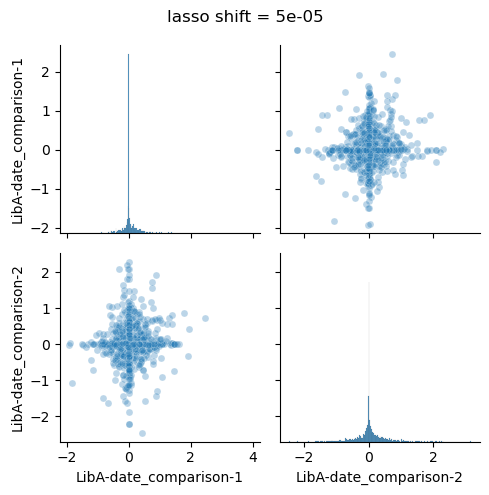

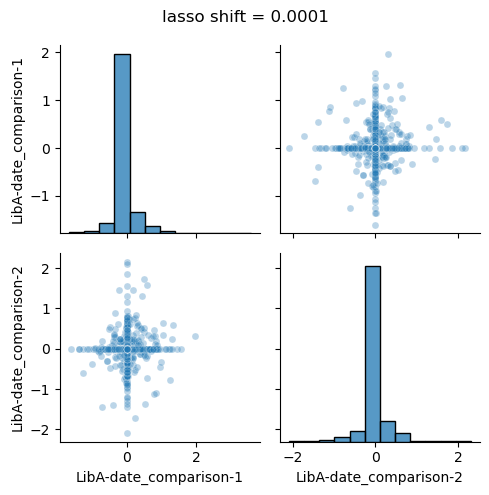

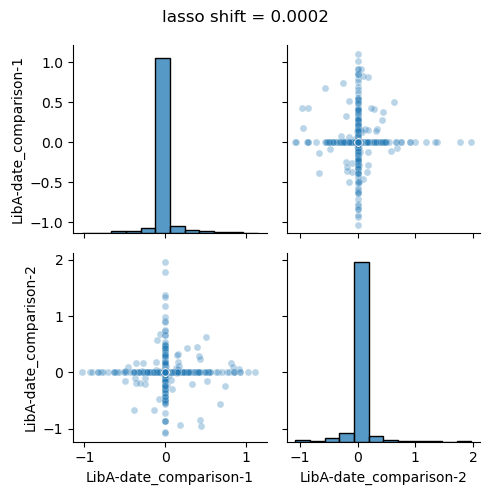

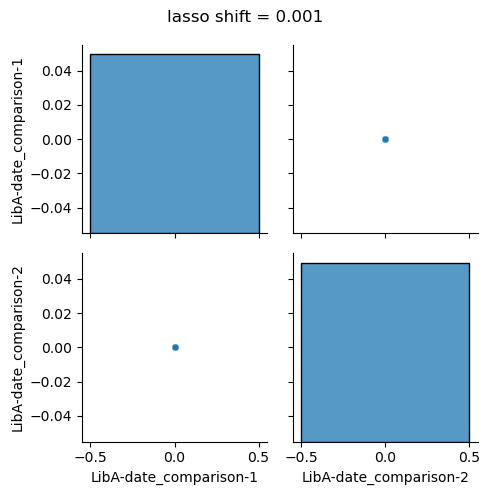

In [5]:
shift_cols = [c for c in shifts.columns if c.startswith("shift_")]

shifts_tidy = shifts.query("wildtype != mutant").melt(
    id_vars=["comparison", "site", "mutant", "lasso_shift", "times_seen"],
    value_vars=shift_cols,
    var_name="condition",
    value_name="shift",
)

shifts_comparison_pivoted = shifts_tidy.pivot_table(
    index=["site", "mutant", "lasso_shift", "condition", "times_seen"],
    values="shift",
    columns="comparison",
).reset_index()

for lasso_shift, df in shifts_comparison_pivoted.groupby("lasso_shift"):
    grid = seaborn.pairplot(
        df.query("times_seen >= 3"),
        vars=comparisons,
        hue=(
            None if shifts_comparison_pivoted["condition"].nunique() == 1
            else "condition"
        ),
        plot_kws={"alpha": 0.3, "s": 25},
    )
    grid.fig.suptitle(f"lasso shift = {lasso_shift}")
    grid.fig.tight_layout()